In [1]:
# standart libs
import random
import copy
from operator import itemgetter

# 3rd party libs
import pandas as pd
import numpy as np
import gempy as gp
import matplotlib.pyplot as plt

# local
import functions.realization_setup as real_setup
import functions.realization_run as real_run
import functions.post_processing as post_pro

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Init the geo_model

In [2]:
# instantiate the geo_model
geo_model = gp.create_model("GeoModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[1, 1, 1]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


# Model data

### Model 1

In [3]:
# meta
geo_model_extent_1 = [0,1000,0,1000,0,1000]
section_1 = {
    'p1': [0, 500],
    'p2': [1000, 500],
    'resolution': [200, 200]
}

# sereis
series_df_1 = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df_1.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df_1.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

# surfaces
surfaces_df_1 = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df_1.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df_1.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }
surfaces_df_1.loc[1] = { 'name': 'rock2', 'serie': 'Strat_Series', 'order_surface': 2 }

# geoData
surface_points_input_data_1 = pd.read_csv('./data/model2_surface_points.csv')
orientaions_input_data_1 = pd.read_csv('./data/model2_orientations.csv')

# Format geological_input_data
surface_points_original_df_1 = surface_points_input_data_1[['X', 'Y', 'Z', 'formation']]

# rename colums
surface_points_original_df_1.columns = ['X', 'Y', 'Z', 'surface']

# add distribution type and parameter
surface_points_original_df_1['param1'] = 10

# Orientaions
orientations_original_df_1 = orientaions_input_data_1[['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation']]

In [4]:
# %%timeit
# setup model 1
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent_1,
        section=section_1,
        series_df=series_df_1,
        surfaces_df=surfaces_df_1,
        surface_points_original_df=surface_points_original_df_1,
        orientations_original_df=orientations_original_df_1
)

Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()


In [5]:
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

Run realizations setup checks until stable workflow.


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


In [6]:
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

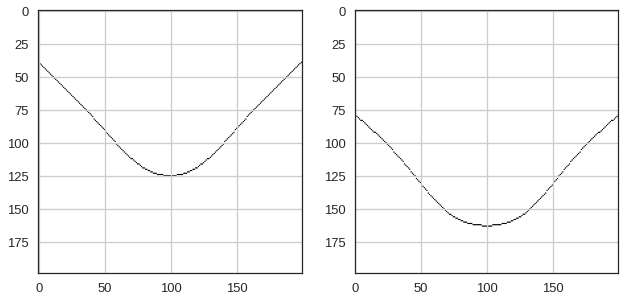

In [7]:
# plot for sanity check
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(Bx['0-1'])
ax1.grid()
ax2.imshow(Bx['0-2'])
ax2.grid()
plt.show()

In [18]:
extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

(2, 200)


(3, 200, 200)

In [19]:
tops_dict = {}
for key in Bx.keys():
    
    boolean_matrix_top = Bx[key]
    xyz_coord_dict = {
        'xvals': section_coordinates[0,:-1,:][boolean_matrix_top].tolist(),
        'yvasl': section_coordinates[1,:-1,:][boolean_matrix_top].tolist(),
        'zvals': section_coordinates[2,:-1,:][boolean_matrix_top].tolist()
    }
    tops_dict[key] = xyz_coord_dict

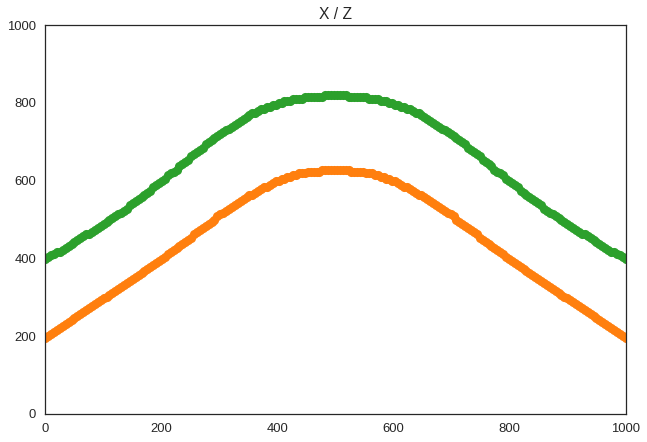

In [23]:
fig, (ax1) = plt.subplots(1, 1)
for key in tops_dict.keys():
    
    xyz = tops_dict[key]
    ax1.plot(
        xyz['xvals'],
        xyz['zvals'],
        'o'
    )
    
ax1.set_title('X / Z')
ax1.set_xlim(0,1000)
ax1.set_ylim(0,1000)
fig.savefig('section_tops_plot.png')
plt.show()

### Model 2

In [24]:
geo_model_extent_2 = [0,2000,0,2000,0,2000]
section_2 = {
    'p1': [0, 1000],
    'p2': [2000, 1000],
    'resolution': [200, 200]
}

series_df_2 = pd.read_csv('./data/simple_fault_model_series.csv')
series_df_2['order_surface'] = [0,1]
surfaces_df_2 = pd.read_csv('./data/simple_fault_model_surfaces.csv')
surfaces_df_2['order_surface'] = [0,1,2,3,4,5]

surface_points_input_data_2 = pd.read_csv('./data/simple_fault_model_points.csv')
orientaions_input_data_2 = pd.read_csv('./data/simple_fault_model_orientations.csv')

# Format geological_input_data
surface_points_original_df_2 = surface_points_input_data_2[['X', 'Y', 'Z', 'formation']]

# rename colums
surface_points_original_df_2.columns = ['X', 'Y', 'Z', 'surface']

# add distribution type and parameter
surface_points_original_df_2['param1'] = 10

# Orientaions
orientations_original_df_2 = orientaions_input_data_2[['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation']]

In [25]:
# %%timeit
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent_2,
        section=section_2,
        series_df=series_df_2,
        surfaces_df=surfaces_df_2,
        surface_points_original_df=surface_points_original_df_2,
        orientations_original_df=orientations_original_df_2
)

Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Fault colors changed. If you do not like this behavior, set change_color to False.


In [26]:
solution = gp.compute_model(model=geo_model, sort_surfaces=False)

In [27]:
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

Run realizations setup checks until stable workflow.


In [28]:
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

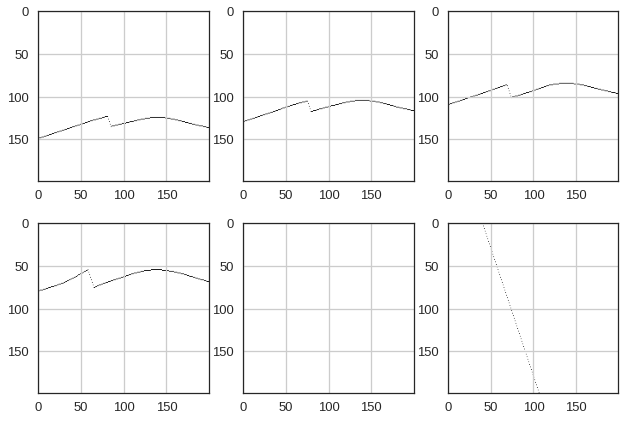

In [29]:
# plot for sanity check
fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(Bx['1-1'])
axs[0,0].grid()
axs[0,1].imshow(Bx['1-2'])
axs[0,1].grid()
axs[0,2].imshow(Bx['1-3'])
axs[0,2].grid()
axs[1,0].imshow(Bx['1-4'])
axs[1,0].grid()
axs[1,1].imshow(Bx['1-0'])
axs[1,1].grid()
axs[1,2].imshow(Bx['0-1'])
axs[1,2].grid()
plt.show()

In [30]:
extent = { 'z_min': 0, 'z_max': 2000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

(2, 200)


In [31]:
tops_dict = {}
for key in Bx.keys():
    
    boolean_matrix_top = Bx[key]
    xyz_coord_dict = {
        'xvals': section_coordinates[0,:-1,:][boolean_matrix_top].tolist(),
        'yvasl': section_coordinates[1,:-1,:][boolean_matrix_top].tolist(),
        'zvals': section_coordinates[2,:-1,:][boolean_matrix_top].tolist()
    }
    tops_dict[key] = xyz_coord_dict

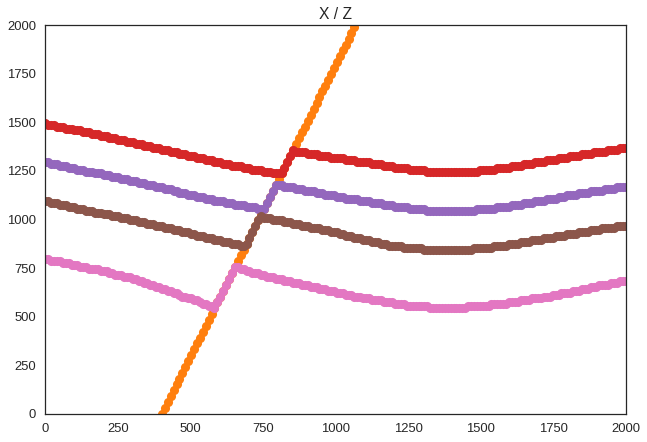

In [33]:
fig, (ax1) = plt.subplots(1, 1)
for key in tops_dict.keys():
    
    xyz = tops_dict[key]
    ax1.plot(
        xyz['xvals'],
        xyz['zvals'],
        'o'
    )
    
ax1.set_title('X / Z')
ax1.set_xlim(0,2000)
ax1.set_ylim(0,2000)
fig.savefig('section_tops_plot.png')
plt.show()